# Influencers in Social Networks
Albert Byun, Hussein Danish, Nick Hamlin, Vincent Chio, Walter Erquinigo Pezo

## Background 

See https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network/data for more info on the problem setup. An example solution is available at https://gist.github.com/fhuszar/5372873

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
import networkx as nx

## Data Ingest

In [3]:
def load_train_data():
    with open('data/train.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        data = np.loadtxt(f, delimiter=',')
        X, Y = data[:,1:], data[:,:1]
        return features, X, Y.flatten()

def load_test_data():
    with open('data/test.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        return np.loadtxt(f, delimiter=',')

def prepare_train_data(X, Y, test_size=1.0/2):
    np.random.seed(0)
    
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, Y = X[shuffle], Y[shuffle]
    break_point = int(X.shape[0] * (1 - test_size))
    return X[:break_point], Y[:break_point], X[break_point:], Y[break_point:]


features, X, Y = load_train_data()
train_data, train_labels, dev_data, dev_labels = prepare_train_data(X, Y)
test_data = load_test_data()

train_data = np.array(train_data)
dev_data = np.array(train_data)
test_data = np.array(test_data)

print train_data.shape, dev_data.shape, test_data.shape

(2750, 22) (2750, 22) (5952, 22)


In [6]:
def transform_features(x):
    return np.log(1+x)

def subtract(x):
    return np.array([xx[0:11] - xx[11:] for xx in x])

def trans(x):
    A = x[:,:11]
    B = x[:,11:]
    
    AA = np.log(1 + A)
    BB = np.log(1 + B)

    return AA - BB

def hash(a):
    base = 100
    res = 0
    for i in range(len(a)):
        res += base ** i * a[i]
    return res

def get_edges(x):
    A = x[:,:11]
    B = x[:,11:]

    mapa = {}
    tot = 0
    edges = []
    adj = {}
    for i in range(len(A)):
        a = hash(list(A[i]))
        if a not in mapa:
            mapa[a] = tot
            adj[tot] = set()
            tot += 1
        b = hash(list(B[i]))
        if b not in mapa:
            mapa[b] = tot
            adj[tot] = set()
            tot += 1
        edges.append((mapa[a], mapa[b]))
        adj[mapa[a]].add(mapa[b])
        adj[mapa[b]].add(mapa[a])
    return edges, tot, adj

def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(0.6 if prob[1] == 0.5 else prob[1])+'\n')

In [8]:
def fix(a, b):
    return np.log(1 + a) - np.log(1 + b)

def graph_features(x1, x2):
    x = np.concatenate((x1, x2))
    edges, n, adj = get_edges(x)
    ug = nx.Graph()
    map(lambda i: ug.add_node(i), range(n))
    map(lambda (a, b): ug.add_edge(a, b), edges)
    
    pr = nx.pagerank(ug)
    degc = nx.degree_centrality(ug)
    close = nx.closeness_centrality(ug)
    load = nx.load_centrality(ug)
    bet = nx.betweenness_centrality(ug)
    ecc = nx.eccentricity(ug)

    
    features = []
    for i in range(len(x)):
        a = edges[i][0]
        b = edges[i][1]
        features.append([
            fix(degc[a], degc[b]),
            fix(close[a], close[b]),
            fix(len(adj[a]), len(adj[b])),
            fix(load[a], load[b]),
            fix(bet[a], bet[b]),
            fix(ecc[a], ecc[b]),
            fix(pr[a], pr[b])
        ])
    return features[:len(x1)], features[len(x1):]

x = trans(X)
test_x = trans(test_data)
x_feat, test_x_feat = graph_features(x, test_x)

x = np.concatenate((x, x_feat), axis=1)
test_x = np.concatenate((test_x, test_x_feat), axis=1)

In [23]:
#0.86116
xx = []
yy = []
for i in range(len(Y)):
    xx.append(x[i])
    yy.append(Y[i])
    xx.append(-x[i])
    yy.append(1 - Y[i])

for i in range(len(xx)):
    xx[i] = np.append(xx[i], xx[i][0] / (xx[i][1] + 1)) 
    xx[i] = np.append(xx[i], xx[i][3] / (xx[i][5] + 1)) 
tx = []
for i in range(len(test_x)):
    tx.append(np.append(test_x[i], test_x[i][0] / (test_x[i][0] + 1)))
    tx[i] = np.append(tx[i], test_x[i][3] / (test_x[i][5] + 1))
    
clf = BaggingClassifier(
    LogisticRegression(C=1/.60),
    max_samples=0.3, max_features=0.7, n_estimators=200, n_jobs=-1, random_state=3)
clf.fit(xx, yy)
proba = clf.predict_proba(tx)
generate_test_output(proba)

In [19]:
clf = GradientBoostingClassifier(n_estimators=200, max_depth=2, max_features=.7, subsample=0.9)
clf.fit(xx, yy)
proba = clf.predict_proba(tx)
generate_test_output(proba)

In [22]:
# 0.86161
clf = BaggingClassifier(
    LogisticRegression(C=1/.60),
    max_samples=0.3, max_features=0.7, n_estimators=200, n_jobs=-1, random_state=3)
clf.fit(xx, yy)
proba1 = clf.predict_proba(tx)

clf = BaggingClassifier(
    GradientBoostingClassifier(max_depth=2, max_features=.99, subsample=0.9),
    max_samples=0.3, max_features=0.7, n_estimators=50, n_jobs=-1, random_state=1
)
clf.fit(xx, yy)
proba2 = clf.predict_proba(tx)
generate_test_output(proba1 * .72 + proba2 * .28)

In [16]:
generate_test_output(proba1 * .72 + proba2 * .28)

In [57]:
class ConditionalClassifier:
    def __init__(self, clf_in, clf_out, radius_ratio_limit = 0.3):
        self.radius_ratio_limit = radius_ratio_limit
        self.clf_in = clf_in
        self.clf_out = clf_out
        
    def fit(self, X, Y):
        self.center = np.average(X)
        self.radius = max(map(lambda x: self.dist(x), X))
        
        x_in, y_in, x_out, y_out = [], [], [], []
        for x, y in zip(X, Y):
            if self.is_in(x):
                x_in.append(x)
                y_in.append(y)
            else:
                x_out.append(x)
                y_out.append(y)
        self.clf_in.fit(x_in,  y_in)
        self.clf_out.fit(x_out, y_out)
        
        
    def dist(self, b):
        return np.linalg.norm(self.center - b)
    
    def get_params(self, deep=False):
        return {
            'clf_in': self.clf_in,
            'clf_out': self.clf_out,
            'radius_ratio_limit': self.radius_ratio_limit
        }
    def is_in(self, b):
        return self.dist(b) / self.radius <= self.radius_ratio_limit
    
    def predict(self, X):
        return [
            self.clf_in.predict(x) if self.is_in(x) else self.clf_out.predict(x)
            for x in X
        ]
    def predict_proba(self, X):
        return [
            self.clf_in.predict_proba(x)[0] if self.is_in(x) else self.clf_out.predict_proba(x)[0]
            for x in X
        ]
        
clf = ConditionalClassifier(
    clf_in = KNeighborsClassifier(n_neighbors=30, weights='distance'),
    clf_out = LogisticRegression(C=1/60.)
)
clf.fit(train_data, train_labels)

In [184]:
class ConditionalClassifier2:
    def __init__(self):
        self.lr = LogisticRegression(C=1/60.)
        self.n = 100
        self.knn = KNeighborsClassifier(n_neighbors=self.n)
        
    def fit(self, X, Y):
        self.lr.fit(X, Y)
        self.knn.fit(X, Y)
        self.X = X
        self.Y = Y        
        
    def dist(self, b):
        return np.linalg.norm(b)
    
    def get_params(self, deep=False):
        return {}
    
    def should_knn(self, X):
        answer = []
        for x in X:
            dist, nei = self.knn.kneighbors([x], self.n)
            a, b = 0, 0
            for i in nei[0]:
                if self.Y[i] == 0:
                    a += 1
                else:
                    b += 1
            if min(a, b) <= -1:
                if a > b:
                    answer.append(0)
                else:
                    answer.append(1)
            else:
                answer.append(-1)
        return answer
    def predict(self, X):
        classes = []
        ans = self.should_knn(X)
        for i in range(len(X)):
            if ans[i] == -1:
                classes.append(self.lr.predict(X[i])[0])
            else:
                classes.append(ans[i])
            
        return np.array(classes)
    def predict_proba(self, X):
        res = []
        ans = self.should_knn(X)
        for i in range(len(X)):
            if ans[i] == -1:
                res.append(self.lr.predict_proba([X[i]])[0])
            else:
                res.append([1 - ans[i], ans[i]])
        return np.array(res)
        

clf = ConditionalClassifier2()
clf.fit(train_data, train_labels)
print clf.predict(train_data[:2])
print clf.predict_proba(train_data[:2])

def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')

x = trans(X)
test_x = trans(test_data)

clf = ConditionalClassifier2()
clf.fit(x, Y)
proba = clf.predict_proba(test_x)
generate_test_output(proba)

[ 0.  0.]
[[ 0.62455689  0.37544311]
 [ 0.5873749   0.4126251 ]]


In [167]:
def cross(x_train, y_train, x_test, y_test,c):
    
    clf1 = LogisticRegression(C=c)
    clf2 = RandomForestClassifier()
    clf3 = GaussianNB()
    clf4 = KNeighborsClassifier(n_neighbors=30, weights='distance')  
    clf5 = ConditionalClassifier(
        clf_in = KNeighborsClassifier(n_neighbors=30, weights='distance'),
        clf_out = LogisticRegression(C=1/60.),
        radius_ratio_limit = 0.3
    )
    #clf6 = BaggingClassifier(LogisticRegression(C=1/.60),max_samples=0.8, max_features=0.7, n_estimators=200)
    clf7 = ConditionalClassifier2()
    x = x_test + x_train
    
    for clf, label in zip(
        [clf1, clf2, clf3, clf4, clf5, clf7], 
        ['Logistic Regression', 'Random Forest', 'naive Bayes', 'knn', 'conditional', 'conditional2']):
        scores = cross_val_score(
            clf, 
            x, 
            y_test + y_train, 
            cv=10, 
            scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

    return 0

print cross(
    trans(dev_data), 
    dev_labels, 
    trans(train_data),
    train_labels,
    1/60.)

Accuracy: 0.48 (+/- 0.02) [Logistic Regression]
Accuracy: 0.43 (+/- 0.02) [Random Forest]
Accuracy: 0.42 (+/- 0.02) [naive Bayes]
Accuracy: 0.47 (+/- 0.02) [knn]
Accuracy: 0.47 (+/- 0.02) [conditional]
Accuracy: 0.49 (+/- 0.02) [conditional2]
0


1594
449
1145


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


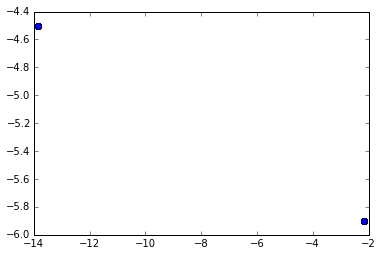

In [91]:
def explore():
    pca = PCA(n_components=2)
    x_dev = pca.fit_transform(trans(dev_data))
    x_train = pca.transform(trans(train_data))
    
    clf = LogisticRegression(C=1/60.)
    clf.fit(x_dev, dev_labels)
    
    pred = clf.predict(x_train)
    wrong = pred != train_labels
    print sum(wrong)
    
    reds = [wrong[i] and train_labels[i] == 1.0 for i in range(len(wrong))]
    blues = [wrong[i] and train_labels[i] == 0.0 for i in range(len(wrong))]
    print sum(reds)
    print sum(blues)
    
    plt.plot(x_train[reds, 0], x_train[reds, 1], "ro", alpha=0.6)
    plt.plot(x_train[blues, 0], x_train[blues, 1], "bo", alpha=0.6)
        
explore()

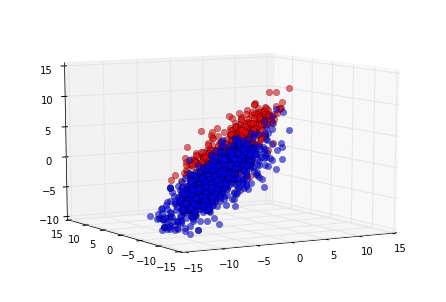

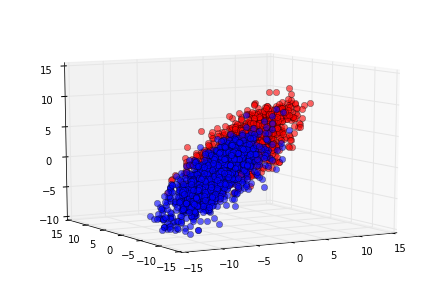

In [126]:
from mpl_toolkits.mplot3d import Axes3D
def filter_by_class(boolean, x, y):
    reds = []
    blues = []
    for i in range(len(boolean)):
        if boolean[i]:
            if y[i] == 1.0:
                reds.append(x[i])
            else:
                blues.append(x[i])
    reds = np.array(reds)
    blues = np.array(blues)
    return (reds, blues)

def plot():
    x_dev = trans(dev_data)[:,:3]
    x = trans(train_data)[:,:3]
    
    clf = LogisticRegression(C=1/60.)
    clf.fit(x_dev, dev_labels)
    
    pred = clf.predict(x)
    
    reds, blues = filter_by_class(pred != train_labels, x, train_labels)
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(elev=10., azim=240)
    ax.plot(reds[:,0], reds[:,1], reds[:,2], "ro", alpha=0.6)
    ax.plot(blues[:,0], blues[:,1], blues[:,2], "bo", alpha=0.6)
    #fig.show()
    
    reds, blues = filter_by_class(pred == train_labels, x, train_labels)
    #fig = plt.figure()
    #ax = Axes3D(fig)
    #ax.plot(reds[:,0], reds[:,1], reds[:,2], "rx", alpha=0.6)
    #ax.plot(blues[:,0], blues[:,1], blues[:,2], "bx", alpha=0.6)
    fig.show()

    
    reds, blues = filter_by_class([True for i in range(len(pred))], x, train_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(elev=10., azim=240)
    ax.plot(reds[:,0], reds[:,1], reds[:,2], "ro", alpha=0.6)
    ax.plot(blues[:,0], blues[:,1], blues[:,2], "bo", alpha=0.6)
    fig.show()
plot()

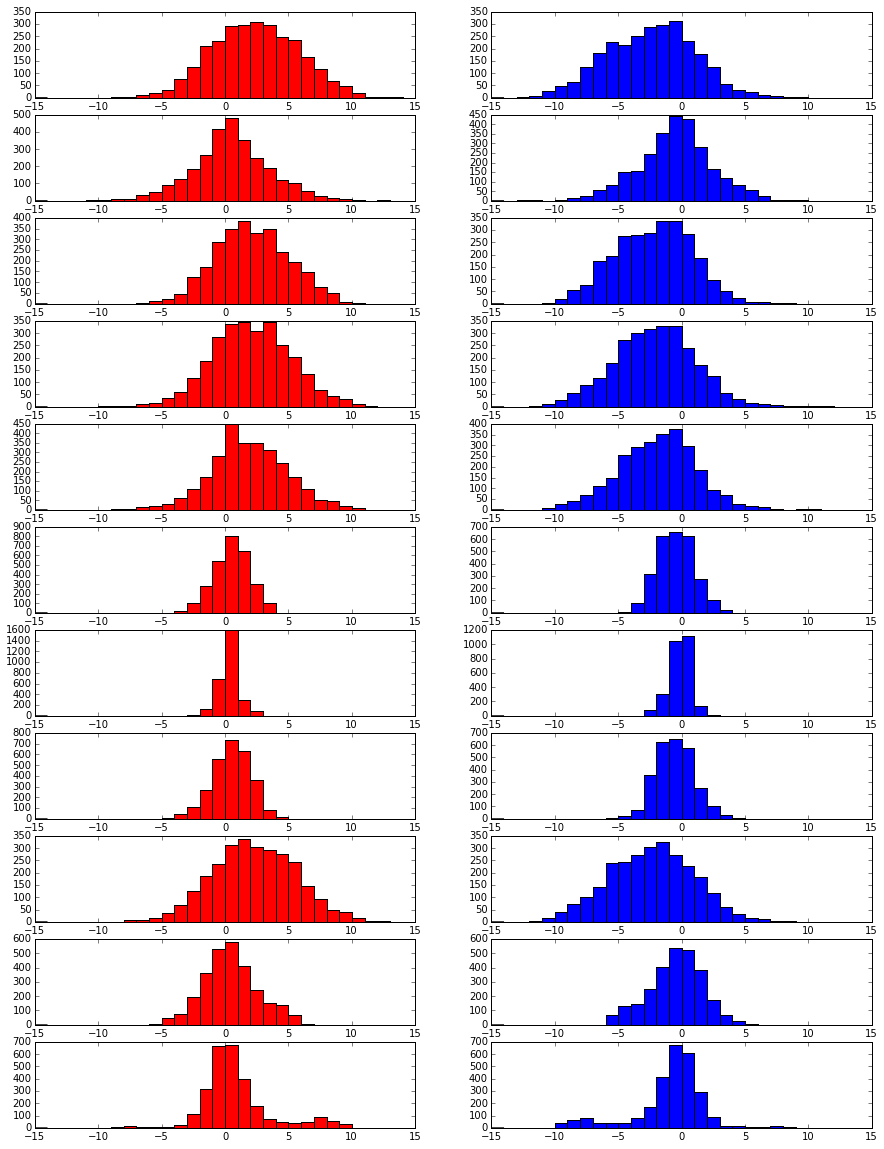

In [161]:
def p():
    reds = Y == 1.
    blues = Y == 0.
    x = trans(X)
    tot = 0
    plt.figure(figsize=(15, 20))
    for i in range(11):
        plt.subplot(11, 2, tot + 1)
        plt.hist(x[reds, i], bins=30, range=(-15, 15), color="red")
        
        plt.subplot(11, 2, tot + 2)
        plt.hist(x[blues, i], bins=30, range=(-15, 15))
        tot += 2
p()

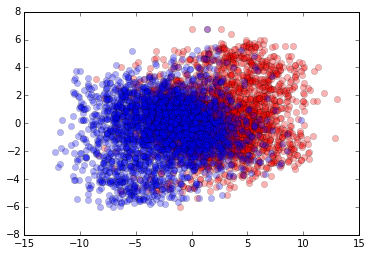

In [168]:
def p2():
    x = trans(X)
    reds = Y == 1.
    blues = Y == 0.
 
    plt.plot(x[reds, 0], x[reds, 9], "ro", alpha=0.3)
    plt.plot(x[blues, 0], x[blues, 9], "bo", alpha=0.3)
    
p2()

## Export Results for Kaggle Submission

In [169]:
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')

x = trans(X)
test_x = trans(test_data)
u = 0#np.mean(x)
s = 1#np.std(x)

clf = ConditionalClassifier2()
clf.fit((x - u) / s, Y)
proba = clf.predict_proba((test_x - u) / s)
generate_test_output(proba)

In [266]:
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')


x = subtract(transform_features(X))#[:,(0, 2, 3, 4, 9)]
test_x = subtract(transform_features(test_data))#[:,(0, 2, 3, 4, 9)]
u = np.mean(x)
s = np.std(x)
clf = linear_model.LogisticRegression(fit_intercept=True, C=1/.60)
clf.fit((x - u) / s, Y)
proba = clf.predict_proba((test_x - u) / s)
    
generate_test_output(proba)

0.773454545455


In [267]:

#0.86099
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')


x = subtract(transform_features(X))#[:,(0, 2, 3, 4, 9)]
test_x = subtract(transform_features(test_data))#[:,(0, 2, 3, 4, 9)]
u = np.mean(x)
s = np.std(x)
clf = linear_model.LogisticRegression(fit_intercept=True, C=1/.60)
#clf = KNeighborsClassifier(n_neighbors=20)
clf.fit((x - u) / s, Y)
proba = clf.predict_proba((test_x - u) / s)
    
generate_test_output(proba)

In [12]:
#0.86104
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(0.6 if prob[1] == 0.5 else prob[1])+'\n')

def tr(x):
    A = x[:,:11]
    B = x[:,11:]
    
    AA = np.log(1 + A)
    BB = np.log(1 + B)

    return np.concatenate(
        (AA - BB, AA, BB),
        axis=1
    )

x = tr(X)
test_x = tr(test_data)
    
u = np.mean(x)
s = np.std(x)
clf = bagging = BaggingClassifier(
    LogisticRegression(C=1/.60),
    max_samples=0.3, max_features=0.7, n_estimators=200, n_jobs=-1, random_state=1)

clf = LogisticRegression(C=1)
clf.fit((x - u) / s, Y)
proba = clf.predict_proba((test_x - u) / s)
    
generate_test_output(proba)